In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

def plot_windows(window):
    # Tring fft on co2 data
    co2 = pd.read_csv("../data/co2.csv")

    co2["date"] = pd.to_datetime(co2["date"], format = '%Y-%m-%d')

    dt = 1 / 12 # yearly freq
    t = np.array(co2["date"])

    f = np.array(co2["CO2"])


    n = len(t)
    #Compute FFT
    fhat = np.fft.fft(f, n)
    # Power Spectrum
    PSD = fhat * np.conj(fhat) / n

    if window == "tukey":
        window = signal.tukey(len(f))
    else:
        window = get_window(window, len(f))

    PSD = PSD*window
    # X axis of freqs
    freq = (1 / (dt*n)) * np.arange(n)

    # Plotting first half
    L = np.arange(1, np.floor(n/2), dtype = 'int')


    # Use the PSD to filter out noise
    # Filter out freqs with low power
    peaks = int(np.quantile(PSD, .985))
    indices = PSD < peaks


    PSDclean = PSD * indices
    # Zero out small Fourier coefs
    fhat_clean = indices * fhat
    # Inverse FFT for filtered time signal
    ffilt = np.fft.ifft(fhat_clean)

    # Filter out freqs with high power
    indices_seasonal = PSD >= peaks


    PSD_seasonal = PSD * indices
    fhat_seasonal = indices_seasonal * fhat
    ffilt_seasonal = np.fft.ifft(fhat_seasonal)


    fig, axes = plt.subplots(5, 1)

    plt.sca(axes[0])
    plt.plot(freq[L], PSD[L], color = 'c')
    plt.xlim(freq[L[0]], freq[L[-1]])
    plt.xlabel("Freq (1/yr)")
    plt.ylabel("FFT")

    plt.sca(axes[1])
    plt.plot(t, f, color = 'c')
    plt.xlim(t[0], t[-1])
    plt.xlabel("Year")
    plt.ylabel("CO2 Emissions")


    plt.sca(axes[2])
    plt.plot(t, ffilt, color = 'k')
    plt.xlim(t[0], t[-1])

    plt.sca(axes[3])
    print(pd.Series(ffilt_seasonal, index = co2["date"]))
    plt.plot(t, ffilt_seasonal, color = "red")
    plt.xlim(t[0], t[-1])



    # Find the residuals 
    residuals = co2["CO2"] - ffilt_seasonal - ffilt
    plt.sca(axes[4])
    plt.scatter(t, residuals)
    plt.xlim(t[0], t[-1])

    plt.show()

    # Initial Statistical Summary
    print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
    print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))

In [102]:
from scipy.signal import get_window
window_slider = wg.SelectionSlider(
    options = ["boxcar", "blackman", "hanning", "tukey"],
    value = "boxcar",
    description = "window",
    disabled = False,
    continuous_update = True,
    orientation = "horizontal",
    readout = True
)

wg.interact(plot_windows, window = window_slider)

interactive(children=(SelectionSlider(description='window', options=('boxcar', 'blackman', 'hanning', 'tukey')…

<function __main__.plot_windows(window)>

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
import math

def STF(data, response, date_column, window = "blackman"):
    dt = 1 / 12 # yearly freq
    t = np.array(data[date_column])

    f = np.array(data[response])
    observed = pd.Series(f, data[date_column])

    n = len(t)
    #Compute FFT
    fhat = np.fft.fft(f, n)
    # Power Spectrum
    PSD = fhat * np.conj(fhat) / n

    if window == "tukey":
        window = signal.tukey(len(f))
    else:
        window = get_window(window, len(f))

    PSD = PSD*window
    # X axis of freqs
    freq = (1 / (dt*n)) * np.arange(n)

    # Plotting first half
    L = np.arange(1, np.floor(n/2), dtype = 'int')


    # Use the PSD to filter out noise
    # Filter out freqs with low power
    peaks = int(np.quantile(PSD, .985))
    indices = PSD < peaks


    PSDclean = PSD * indices
    # Zero out small Fourier coefs
    fhat_clean = indices * fhat
    # Inverse FFT for filtered time signal
    ffilt = np.fft.ifft(fhat_clean)

    # Filter out freqs with high power
    indices_seasonal = PSD >= peaks


    PSD_seasonal = PSD * indices
    fhat_seasonal = indices_seasonal * fhat
    ffilt_seasonal = np.fft.ifft(fhat_seasonal)


    fig, axes = plt.subplots(5, 1)

    plt.sca(axes[0])
    plt.plot(freq[L], PSD[L], color = 'c')
    plt.xlim(freq[L[0]], freq[L[-1]])
    plt.xlabel("Freq (1/yr)")
    plt.ylabel("FFT")

    plt.sca(axes[1])
    plt.plot(t, f, color = 'c')
    plt.xlim(t[0], t[-1])
    plt.xlabel("Year")
    plt.ylabel("CO2 Emissions")


    plt.sca(axes[2])
    plt.plot(t, ffilt, color = 'k')
    trend = pd.Series(ffilt, data[date_column])
    plt.xlim(t[0], t[-1])

    plt.sca(axes[3])
    # This will be res.seasonal (ffilt_seasonal)
    seasonal = pd.Series(ffilt_seasonal, data[date_column])
    plt.plot(t, ffilt_seasonal, color = "red")
    plt.xlim(t[0], t[-1])



    # Find the residuals 
    residual = data[response] - ffilt_seasonal - ffilt
    resid = pd.Series(residual, data[date_column])
    plt.sca(axes[4])
    plt.scatter(t, residual)
    plt.xlim(t[0], t[-1])

    plt.show()

    # Initial Statistical Summary
    print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
    print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))

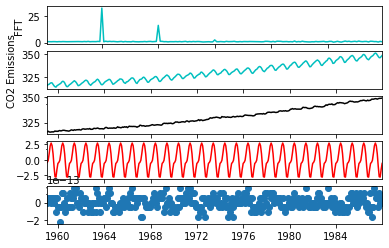

The rmse 7.678518438055154e-14
The dot product of STF seasonal and trend components is  (-0+0j)


In [104]:
co2 = pd.read_csv("../data/co2.csv")

co2["date"] = pd.to_datetime(co2["date"], format = '%Y-%m-%d')
STF(co2, "CO2", "date", "hanning")

In [130]:
class STF:

    # init method or constructor 
    def __init__(self, data, response, window, date):
        self.data = data
        self.response = response
        self.window = window
        self.date = date

    def fit(self):
        
        dt = 1 / 12 # yearly freq
        t = np.array(self.data[self.date])

        f = np.array(self.data[self.response])
        observed = pd.Series(f, self.data[self.date])
        self.observed = observed

        n = len(t)
        #Compute FFT
        fhat = np.fft.fft(f, n)
        # Power Spectrum
        PSD = fhat * np.conj(fhat) / n

        if self.window == "tukey":
            window = signal.tukey(len(f))
        else:
            window = get_window(self.window, len(f))

        PSD = PSD*window
        # X axis of freqs
        freq = (1 / (dt*n)) * np.arange(n)

        # Plotting first half
        L = np.arange(1, np.floor(n/2), dtype = 'int')


        # Use the PSD to filter out noise
        # Filter out freqs with low power
        peaks = int(np.quantile(PSD, .985))
        indices = PSD < peaks


        PSDclean = PSD * indices
        # Zero out small Fourier coefs
        fhat_clean = indices * fhat
        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(fhat_clean)

        # Filter out freqs with high power
        indices_seasonal = PSD >= peaks


        PSD_seasonal = PSD * indices
        fhat_seasonal = indices_seasonal * fhat
        ffilt_seasonal = np.fft.ifft(fhat_seasonal)


        fig, axes = plt.subplots(5, 1)

        plt.sca(axes[0])
        plt.plot(freq[L], PSD[L], color = 'c')
        plt.xlim(freq[L[0]], freq[L[-1]])
        plt.xlabel("Freq (1/yr)")
        plt.ylabel("FFT")

        plt.sca(axes[1])
        plt.plot(t, f, color = 'c')
        plt.xlim(t[0], t[-1])
        plt.xlabel("Year")
        plt.ylabel("CO2 Emissions")


        plt.sca(axes[2])
        plt.plot(t, ffilt, color = 'k')
        self.trend = pd.Series(ffilt, self.data[self.date])
        plt.xlim(t[0], t[-1])

        plt.sca(axes[3])
        # This will be res.seasonal (ffilt_seasonal)
        self.seasonal = pd.Series(ffilt_seasonal, self.data[self.date])
        plt.plot(t, ffilt_seasonal, color = "red")
        plt.xlim(t[0], t[-1])



        # Find the residuals 
        residual = self.data[self.response] - ffilt_seasonal - ffilt
        self.resid = pd.Series(residual, self.data[self.date])
        plt.sca(axes[4])
        plt.scatter(t, residual)
        plt.xlim(t[0], t[-1])

        plt.show()

        # Initial Statistical Summary
        print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        return self
    



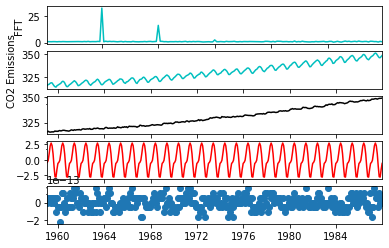

The rmse 7.678518438055154e-14
The dot product of STF seasonal and trend components is  (-0+0j)


date
1959-01-31    315.58
1959-02-28    316.39
1959-03-31    316.79
1959-04-30    317.82
1959-05-31    318.39
               ...  
1987-08-31    347.54
1987-09-30    346.20
1987-10-31    346.20
1987-11-30    347.44
1987-12-31    348.67
Length: 348, dtype: float64

In [131]:
co2["date"] = pd.to_datetime(co2["date"], format = '%Y-%m-%d')
stf = STF(co2, "CO2", "hanning", "date")
fit = stf.fit()
fit.observed
